LOCKDOWN + BEHAVIOURAL

In [1]:
import string         #(module for string)
import sys            #(module system)
import numpy as np    #(module mathematical stuff)
import math
import operator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
from scipy.integrate import solve_ivp
import json
import pandas as pd

In [2]:
f = open('covid_data_dpc.json')
raw_data = json.load(f)

In [3]:
#from dictionary to dataframe
df = pd.DataFrame.from_dict(raw_data)
df.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,tamponi,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,...,4324,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,...,8623,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,...,9587,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,...,12014,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,...,15695,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN


In [4]:
# columns names
df.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido'],
      dtype='object')

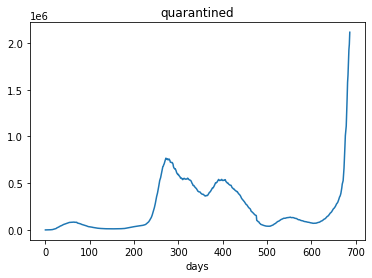

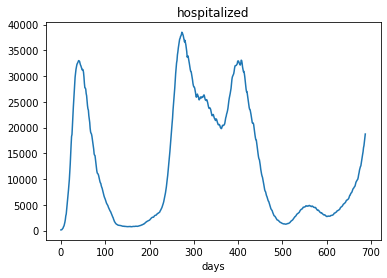

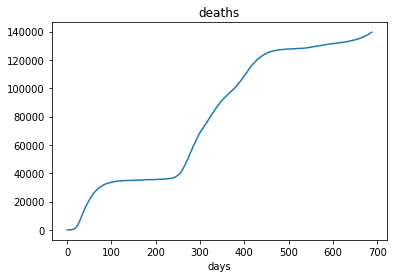

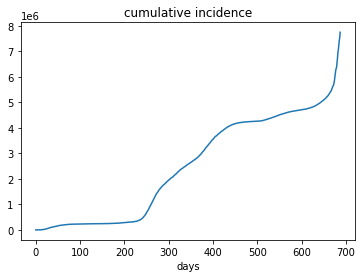

In [5]:
plt.plot(df['isolamento_domiciliare'])
plt.title('quarantined')
plt.xlabel('days')
plt.show()

plt.plot(df['totale_ospedalizzati'])
plt.title('hospitalized')
plt.xlabel('days')
plt.show()

plt.plot(df['deceduti'])
plt.title('deaths')
plt.xlabel('days')
plt.show()

plt.plot(np.cumsum(df['nuovi_positivi']))
plt.title('cumulative incidence')
plt.xlabel('days')
plt.show()

## Data from 24 Feb to 18 May

In [6]:
# dataframe with reduced dates
# from 24/02 to 18/05 
df_red = df.loc[0:84]

In [7]:
eps_p = 1
eps_m = 0.033
eps_s = 0.034
rho = 1.0/5.25
eta = 1/1.25
p = 0.92
gamma0 = 0.057
sigma_m = 0.044
sigma_q = 0.001
delta = 0.022
nu_m = 0.145
nu_s = 0.048
nu_q = 0.035
mu = 10.7/(1000*365)
Lambda = 1.762*1e3

M0 = 101.9
a = 1.0/3
k = 0.8
beta_b = 2.25
csi = 0.01

E0 = 1695
Ip0 = 308.8
Im0 = 462.4
Is0 = 127.4
Q0 = 93.7
R0 = 311.1
S0 = 60.352*1e6

In [8]:
N0 = S0 + E0 + Ip0 + Im0 + Is0 + Q0 + R0
N0

60354998.4

In [9]:
def beta0(t):
    if t>=17 and t<28:
        return 0.64*beta_b
    elif t>=28 and t < 85:
        return 0.74*beta_b
    elif t>=85:
        return 0.74*beta_b
    else:
        return 0

In [10]:
def mymodel(t, z):
    S = z[0]
    E = z[1]
    Ip = z[2]
    Im = z[3]
    Is = z[4]
    Q = z[5]
    R = z[6]
    M = z[7]
    Death = z[8]
    N = S + E + Ip + Im + Is + Q + R
    beta_m = (beta_b-beta0(t))/(1+alpha*M)
    FOI = beta_m*(eps_p*Ip + eps_m*Im + eps_s*Is)/(N-Q)
    gamma1 = (1-gamma0-csi)*D*M/(1+D*M)
    gamma = gamma0+gamma1
    dM = a*(k*(Q+Is)-M)
    dS = Lambda - FOI*S - mu*S
    dE = FOI*S - rho*E - mu*E
    dIp = rho*E - eta*Ip - mu*Ip
    dIm = p*eta*Ip - gamma*Im - sigma_m*Im - nu_m*Im - mu*Im
    dIs = (1-p)*eta*Ip + sigma_m*Im + sigma_q*Q - nu_s*Is - delta*Is - mu*Is
    dQ = gamma*Im - sigma_q*Q - nu_q*Q - mu*Q
    dR = nu_m*Im + nu_s*Is + nu_q*Q - mu*R
    dDeath = delta*Is
    return [dS, dE, dIp, dIm, dIs, dQ, dR, dM, dDeath]

In [11]:
z0 = [S0, E0, Ip0, Im0, Is0, Q0, R0, M0, 0]

In [12]:
D = 9e-6
alpha = 6e-7
sol1 = solve_ivp(mymodel, [0,85], z0, dense_output=True)

In [13]:
D = 0
alpha = 0
sol2 = solve_ivp(mymodel, [0,85], z0, dense_output=True)

In [14]:
t = np.arange(0,85)
x1 = sol1.sol(t)
x2 = sol2.sol(t)

inc1 = np.cumsum(x1[2].T)
inc2 = np.cumsum(x2[2].T)

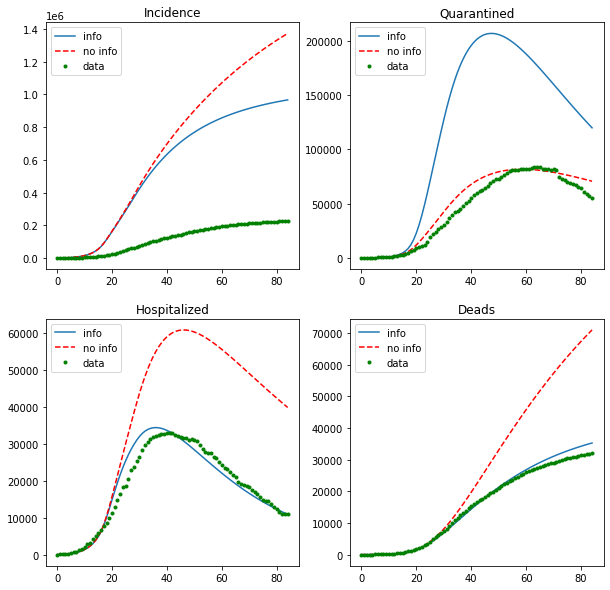

In [15]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))

ax[0,0].plot(t, inc1, label = 'info')
ax[0,0].plot(t, inc2,'r--', label = 'no info')
ax[0,0].plot(np.cumsum(df_red['nuovi_positivi']), 'g.', label = 'data')
ax[0,0].legend()
ax[0,0].set_title('Incidence')

ax[0,1].plot(t, x1[5].T, label = 'info')
ax[0,1].plot(t, x2[5].T,'r--', label = 'no info')
ax[0,1].plot(t, df_red['isolamento_domiciliare'], 'g.', label = 'data')
ax[0,1].legend()
ax[0,1].set_title('Quarantined')

ax[1,0].plot(t, x1[4].T, label = 'info')
ax[1,0].plot(t, x2[4].T,'r--', label = 'no info')
ax[1,0].plot(t, df_red['totale_ospedalizzati'], 'g.', label = 'data')
ax[1,0].legend()
ax[1,0].set_title('Hospitalized')

ax[1,1].plot(t, x1[8].T, label = 'info')
ax[1,1].plot(t, x2[8].T,'r--', label = 'no info')
ax[1,1].plot(t, df_red['deceduti'], 'g.', label = 'data')
ax[1,1].set_title('Deads')
ax[1,1].legend()

plt.show()

In [11]:
E0 = 45
Ip0 = 308.8
Im0 = 462.4
Is0 = 127.4
Q0 = 93.7
R0 = 311.1
S0 = 20*1e6

In [12]:
N0 = S0 + E0 + Ip0 + Im0 + Is0 + Q0 + R0
N0

20001348.4

In [13]:
z0 = [S0, E0, Ip0, Im0, Is0, Q0, R0, M0, 0]

In [26]:
D = 9e-6
alpha = 6e-7
sol1 = solve_ivp(mymodel, [0,100], z0, dense_output=True)
D = 0
alpha = 0
sol2 = solve_ivp(mymodel, [0,100], z0, dense_output=True)

In [27]:
t = np.arange(0,100)
x1 = sol1.sol(t)
x2 = sol2.sol(t)

inc1 = np.cumsum(x1[2].T)
inc2 = np.cumsum(x2[2].T)

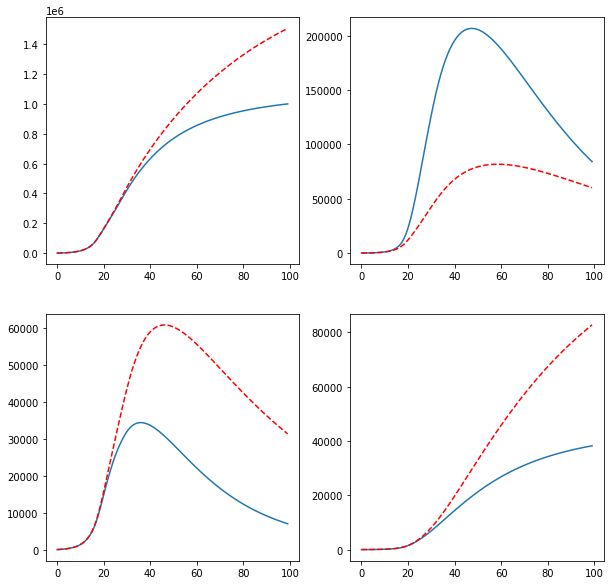

In [28]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
ax[0,0].plot(t, inc1)
ax[0,0].plot(t, inc2,'r--')
ax[0,1].plot(t, x1[5].T)
ax[0,1].plot(t, x2[5].T,'r--')
ax[1,0].plot(t, x1[4].T)
ax[1,0].plot(t, x2[4].T,'r--')
ax[1,1].plot(t, x1[8].T)
ax[1,1].plot(t, x2[8].T,'r--')
plt.show()

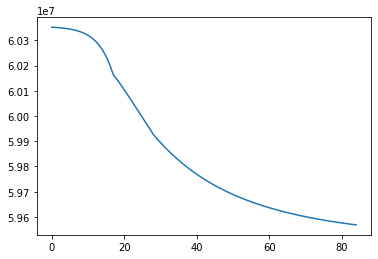

In [16]:
plt.plot(t, x1[0].T)